In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import cv2
from sklearn.model_selection import train_test_split

import rasterio
from sklearn.utils import shuffle
import openslide

import os
import sys
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random
from random import randint

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
import requests
from io import BytesIO
from PIL import Image
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import mean_squared_error
import keras as K
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras import models
from tensorflow.keras.models import load_model


# Load Image Data into dataframe

Generate a dataframe with id, corresponding image path and label from data directories.

In [2]:
def get_image_paths_and_labels(fire_dir, non_fire_dir):
    image_path_list = []
    Labels = []
    
    fire_label = 1
    non_fire_label = 0
    
    #Fetch Image paths from fire directory
    for root, dirs, files in os.walk(fire_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Add more extensions if needed
                image_path = os.path.join(root, file)
                image_path_list.append(image_path)
                Labels.append(fire_label)
    
    # Fetch image paths from the non_fire directory
    for root, dirs, files in os.walk(non_fire_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image_path_list.append(image_path)
                Labels.append(non_fire_label)
    
    return image_path_list, Labels

#Create Dataframe
def create_image_dataframe(image_path_list, Labels):
    # Generate unique image IDs
    image_ids = [f"img_{i+1}" for i in range(len(image_path_list))]
    
    df = pd.DataFrame({
        'image_id': image_ids,
        'image_path': image_path_list,
        'fire': Labels  #1 for fire, 0 for non-fire
    })
    
    return df


fire_dir = "/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train/fire"
non_fire_dir = "/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train/non_fire"
image_path_list, Labels = get_image_paths_and_labels(fire_dir, non_fire_dir)

# Create the DataFrame for train set
df = create_image_dataframe(image_path_list, Labels)
print('Train Data set')
print(df.head())

fire_dir = "/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/test/fire"
non_fire_dir = "/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/test/non_fire"
image_path_list, Labels = get_image_paths_and_labels(fire_dir, non_fire_dir)

# Create DataFrame for test set
test_df = create_image_dataframe(image_path_list, Labels)
print('Test Data set')
print(test_df.head())


Train Data set
  image_id                                         image_path  fire
0    img_1  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
1    img_2  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
2    img_3  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
3    img_4  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
4    img_5  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
Test Data set
  image_id                                         image_path  fire
0    img_1  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
1    img_2  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
2    img_3  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
3    img_4  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
4    img_5  /kaggle/input/firedataset-jpg-224/FireDataset-...     1


The dataframe must be shuffled to mix fire and non_fire images

In [41]:
#Shuffle and split generated dataframe into train and validation sets, with validation ratio 0.2

def shuffle_and_split(df, validation_ratio=0.2):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    train_df, val_df = train_test_split(df, test_size=validation_ratio, random_state=42)
    
    # Reindex the resulting DataFrames from 0
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    
    return train_df, val_df

train_df, val_df = shuffle_and_split(df)

print("Training Set:")
print(train_df.head())

print("\nValidation Set:")
print(val_df.head())


Training Set:
   image_id                                         image_path  fire
0  img_2884  /kaggle/input/firedataset-jpg-224/FireDataset-...     0
1  img_1527  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
2  img_2905  /kaggle/input/firedataset-jpg-224/FireDataset-...     0
3   img_718  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
4  img_2645  /kaggle/input/firedataset-jpg-224/FireDataset-...     0

Validation Set:
   image_id                                         image_path  fire
0  img_1153  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
1  img_1200  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
2   img_346  /kaggle/input/firedataset-jpg-224/FireDataset-...     1
3  img_2226  /kaggle/input/firedataset-jpg-224/FireDataset-...     0
4  img_1225  /kaggle/input/firedataset-jpg-224/FireDataset-...     1


In [42]:
IMAGE_SHAPE =(150,150,3)
BATCH_SIZE=16
IMG_HEIGHT= 150
IMG_WIDTH =150

Opencv image filtering is combined with a neural network for better predictions

In [29]:
fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)


In [43]:
#Applies heatmap, and color masks to each image. 
def apply_masks(image):
    smoke_mask = detect_white_smoke(image)
    
    #Heatmap mask - convert image to grayscale and apply a threshold to find bright regions
    heatmap_mask = generate_heatmap_mask(image)
    
    #Color mask
    color_mask = generate_color_mask(image)

    #Apply edge mask (edge detection in grayscale)
    masked_image1 = cv2.bitwise_and(image, image, mask=smoke_mask)
    # Apply heatmap mask (highlight areas likely to be hot)
    heatmap_mask_colored = cv2.applyColorMap(heatmap_mask, cv2.COLORMAP_JET)  # Apply colormap to create a heatmap effect
    masked_image2 = cv2.addWeighted(image, 0.5, heatmap_mask_colored, 0.5, 0)  # Blend original image with heatmap

    #Generates a color mask by isolating fire-like colors (reds, oranges, yellows).
    output = cv2.bitwise_and(image, image, mask = color_mask)
    output= output/255
    masked_image3 = cv2.GaussianBlur(output, (0, 0), 3)
    masked_image3 = cv2.addWeighted(output, 1.5, masked_image3, -0.5, 0)
    return masked_image1, masked_image2, masked_image3

# def generate_edge_mask(image):
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray_image, 100, 200)  
#     return edges

def generate_heatmap_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray, (5, 5), 5)
    fmask = fgbg.apply(gray_frame)
    kernel = np.ones((20, 20), np.uint8)
    fmask = cv2.medianBlur(fmask, 3)
    fmask = cv2.dilate(fmask, kernel)

    return fmask

def generate_color_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(image, (21, 21), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
 
    a = [18, 50, 50]
    b = [35, 255, 255]
    a = np.array(a, dtype="uint8")
    b = np.array(b, dtype="uint8")
    mask = cv2.inRange(hsv, a, b)
 
 
    return mask
def detect_white_smoke(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_white = np.array([0, 0, 200]) 
    upper_white = np.array([180, 60, 255]) 
    
    mask = cv2.inRange(hsv_image, lower_white, upper_white)
    
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Remove noise
    blurred_mask = cv2.GaussianBlur(mask, (15, 15), 0)
    
    return blurred_mask

Create custom generator to generate 3 seperate versions of the same image to be fed into a multiinput CNN model

In [44]:

def custom_generator(image_path_list, Labels, batch_size=16):
    while True:
        for start in range(0, len(image_path_list), batch_size):
            X_batch_1 = []
            X_batch_2 = []
            X_batch_3 = []
            Y_batch = []
            
            # Ensure that the index doesn't exceed the size of the image_path_list
            end = min(start + batch_size, len(image_path_list))

            for i in range(start, end):
                image_path = image_path_list[i]
                label = Labels[i] 
                
                # Load image 
                image = cv2.imread(image_path)
                image = cv2.resize(image, (150, 150))  # Resize image
                
                # Apply masks
                masked_image1, masked_image2, masked_image3 = apply_masks(image)
                
                #Normalize the images
                masked_image1 = masked_image1 / 255.0
                masked_image2 = masked_image2 / 255.0
                masked_image3 = masked_image3 / 255.0
                
                # Append masked images to respective batches
                X_batch_1.append(masked_image1)
                X_batch_2.append(masked_image2)
                X_batch_3.append(masked_image3)
                
                # Append the relevant label
                Y_batch.append(label)
            
            # Convert to numpy arrays
            X_batch_1 = np.array(X_batch_1)
            X_batch_2 = np.array(X_batch_2)
            X_batch_3 = np.array(X_batch_3)
            
            Y_batch = np.array(Y_batch).reshape(-1, 1)
            
            yield (X_batch_1, X_batch_2, X_batch_3), Y_batch


Test Masks for images

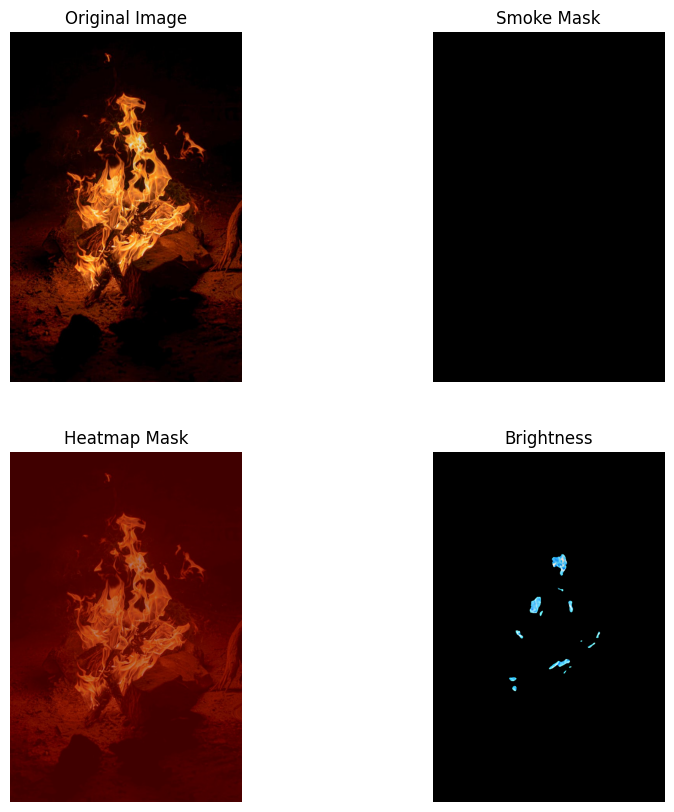

In [62]:
def fetch_and_display_image(url):
    response = requests.get(url)
    image_np = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
    masked_image1, masked_image2, masked_image3 = apply_masks(image)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(masked_image1, cv2.COLOR_BGR2RGB))
    plt.title('Smoke Mask')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(masked_image2, cv2.COLOR_BGR2RGB))
    plt.title('Heatmap Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(masked_image3, cmap='gray')
    plt.title('Brightness')
    plt.axis('off')

    plt.show()

url='https://images.pexels.com/photos/5159914/pexels-photo-5159914.png?auto=compress&cs=tinysrgb&w=600'
fetch_and_display_image(url)


In [50]:
def create_model(IMAGE_SHAPE):
    """
    Creates a CNN model with 3 input branches and a binary output.
    
    Parameters:
    - IMAGE_SHAPE: Shape of each input image (height, width, channels)
    
    Returns:
    - Compiled Keras model
    """
    num_channels = IMAGE_SHAPE[2]

    def branch(input_image):
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        return x

    # Input layers for 3 channels
    input_image1 = layers.Input(shape=IMAGE_SHAPE)
    input_image2 = layers.Input(shape=IMAGE_SHAPE)
    input_image3 = layers.Input(shape=IMAGE_SHAPE)

    # Create Branches for each input
    branch1 = branch(input_image1)
    branch2 = branch(input_image2)
    branch3 = branch(input_image3)

    # Merge all the branches
    merge = layers.Concatenate()([branch1, branch2, branch3])
    dense = layers.Dense(128, activation='relu')(merge)
    dropout = layers.Dropout(0.5)(dense)
    output = layers.Dense(1, activation='sigmoid')(dropout)  # Use sigmoid activation for Binary output

    model = models.Model(inputs=[input_image1, input_image2, input_image3], outputs=output)
    
    #Set the learning rate to a low value for a more stable learning curve
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


# Create and compile the model
model = create_model(IMAGE_SHAPE)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 150, 150,  │        896 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 150, 150,  │        896 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 150, 150,  │        896 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 75, 75,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 75, 75,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 75, 75,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 75, 75,    │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 75, 75,    │     18,496 │ max_pooling2d_23… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 75, 75,    │     18,496 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 37, 37,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 37, 37,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 37, 37,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 37, 37,    │     73,856 │ max_pooling2d_22… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 37, 37,    │     73,856 │ max_pooling2d_24

 Total params: 378,689 (1.44 MB)

 Trainable params: 378,689 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [51]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

# Instantiate the generators
train_generator = custom_generator(train_df["image_path"], train_df["fire"], batch_size=BATCH_SIZE)
val_generator = custom_generator(val_df["image_path"], val_df["fire"], batch_size=BATCH_SIZE)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.6776 - loss: 0.5819 - val_accuracy: 0.8125 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8079 - loss: 0.4370 - val_accuracy: 0.8590 - val_loss: 0.3550 - learning_rate: 0.0010
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8439 - loss: 0.3596 - val_accuracy: 0.8653 - val_loss: 0.3257 - learning_rate: 0.0010
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8554 - loss: 0.3306
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.8554 - loss: 0.3306 - val_accuracy: 0.8628 - val_loss: 0.3316 - learning_rate: 0.0010
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8705 - loss: 0.3070 - val_accuracy: 0.8806 - val_loss: 0.3048 - learning_rate: 5.0000e-04
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.8801 - loss: 0

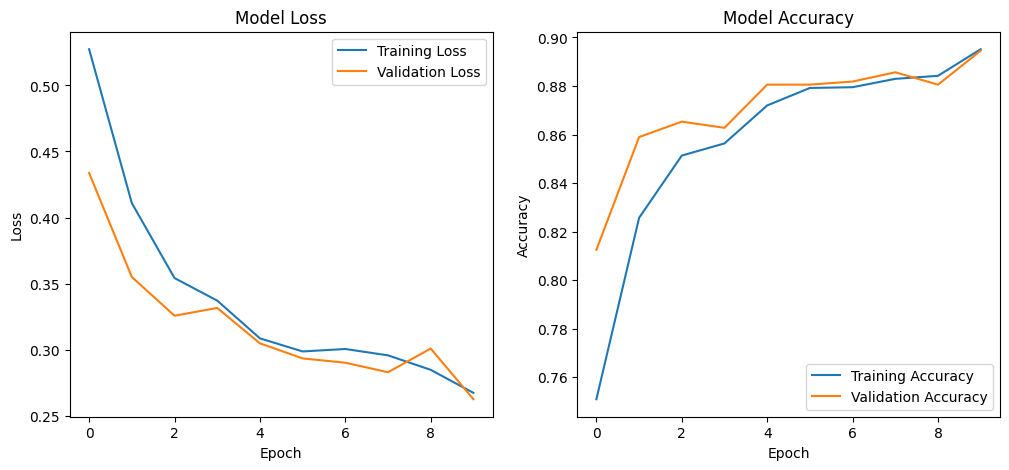

In [52]:
# Plot training & validation loss & accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.show()


In [53]:
model.save('multi_model.h5')

model = load_model('/working/mutli_model.h5')

In [55]:
# get test images
test_data_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/val'

# Create test generator
test_gen = custom_generator(test_df['image_path'],test_df['fire'], BATCH_SIZE)

loss, accuracy = model.evaluate(test_gen, steps=len(test_df['image_path']) // BATCH_SIZE, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.8995 - loss: 0.2650
Test Loss: 0.2718
Test Accuracy: 0.9102


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


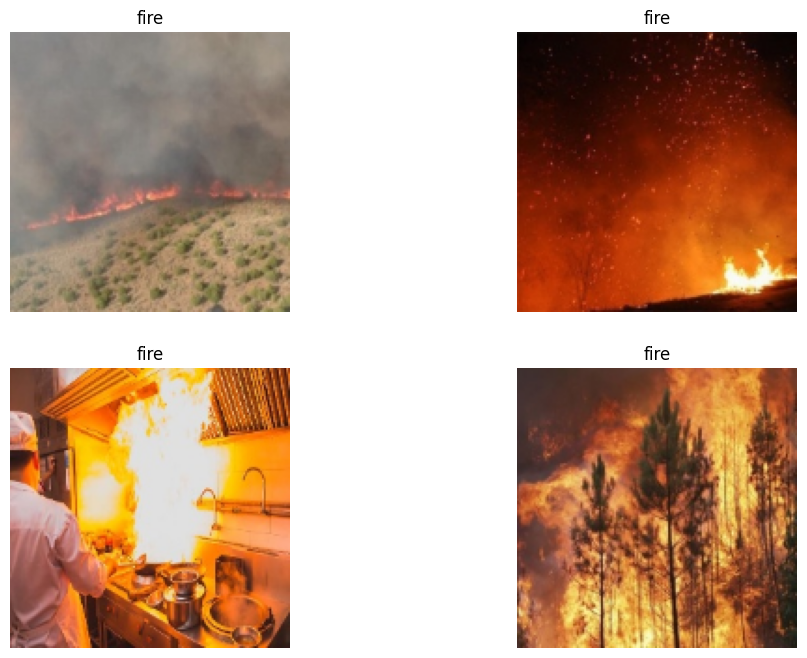

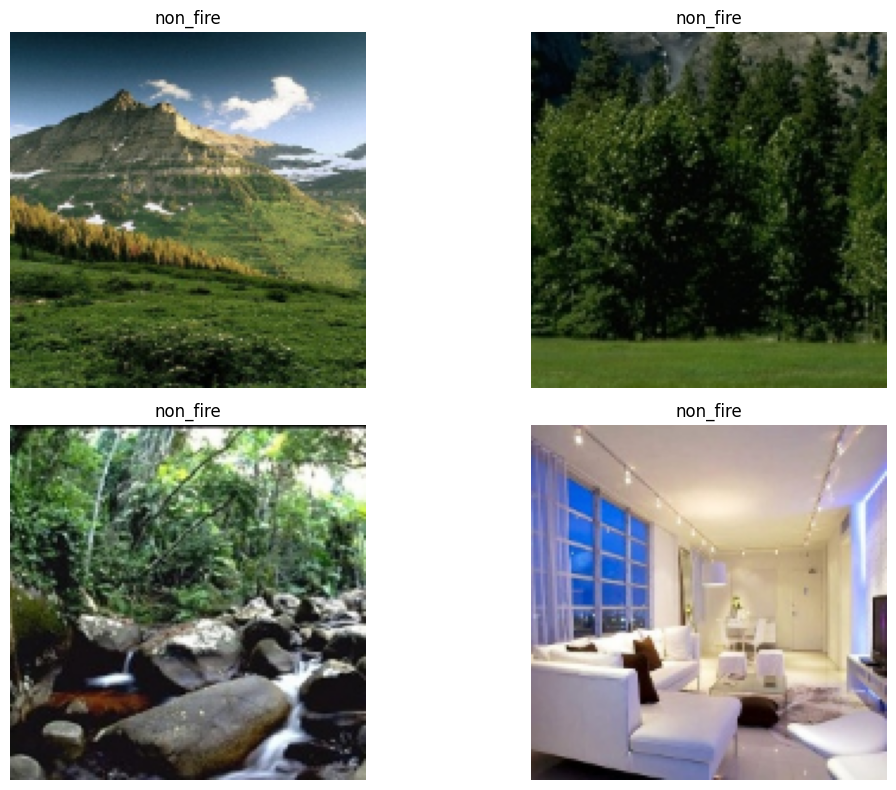

In [57]:
data_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/test'
fire_dir = os.path.join(data_dir, 'fire')
non_fire_dir = os.path.join(data_dir, 'non_fire')

num_images_per_class = 4

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Preprocess images for evaluation
def preprocess_and_predict(image):
    masked_image1, masked_image2, masked_image3 = apply_masks(image)
    
    masked_image1 = masked_image1 / 255.0
    masked_image2 = masked_image2 / 255.0
    masked_image3 = masked_image3 / 255.0
    
    # Stack the images into one input batch
    X_batch_1 = np.expand_dims(masked_image1, axis=0)
    X_batch_2 = np.expand_dims(masked_image2, axis=0)
    X_batch_3 = np.expand_dims(masked_image3, axis=0)
    
    # Predict
    prediction = model.predict([X_batch_1, X_batch_2, X_batch_3])
    return prediction

# Display image with prediction
def plot_images_with_predictions(directory, num_images):
    img_paths = [os.path.join(directory, img) for img in os.listdir(directory)][:num_images]
    
    rows = 2
    cols = num_images // 2 if num_images > 1 else 1
    
    plt.figure(figsize=(12, 8))
    
    for i, img_path in enumerate(img_paths):
        image = load_image(img_path)
        prediction = preprocess_and_predict(image)
        predicted_class = 'fire' if prediction[0] > 0.5 else 'non_fire'
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(predicted_class)
        plt.axis('off')

plot_images_with_predictions(fire_dir, num_images_per_class)
plot_images_with_predictions(non_fire_dir, num_images_per_class)

plt.tight_layout()
plt.show()
